In [1]:
from sklearn import cluster
from sklearn.decomposition import PCA
from collections import Counter
import random
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import wordlexp as we
import importlib
import warnings
warnings.filterwarnings("ignore")

In [80]:
importlib.reload(we)
score_later = we.evaluate_first_word('later', samples=3,  n=500)
score_irate = we.evaluate_first_word('irate', samples=3, n=500)

In [81]:
scores = pd.DataFrame([score_later, score_irate], index=['later', 'irate'])
scores

,speed,loss
later,4.226006,10.0
irate,4.272285,10.6



# Letter Frequency

<AxesSubplot:xlabel='Letter', ylabel='Freq'>

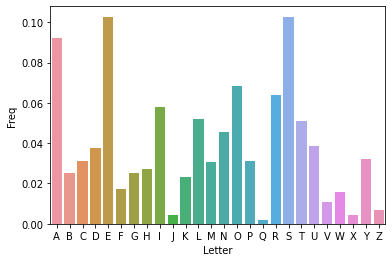

In [83]:
view = np.ravel(we.all_words[we.letter_cols].values)
counts = np.unique(view, return_counts=True)
frequencies = np.asarray(counts).T
data = pd.DataFrame(frequencies, columns=["Letter", "Count"])
data["Freq"] = data["Count"] / data["Count"].sum()
alphabet = [chr(_) for _ in range(ord('A'), ord('Z') + 1)]
sb.barplot(data=data, x="Letter", y="Freq", order=alphabet)
data.set_index('Letter', inplace=True)

Now we can go in and score all the words by their letter frequency.

In [94]:
def word_freq_sum(word):
    return sum([data.loc[_]["Freq"] for _ in word])
word_scores = we.all_words["word"].apply(word_freq_sum).to_frame("score")
word_scores["word"] = we.all_words["word"]
word_scores['uniq'] = we.all_words['unique']
word_scores['valid'] = we.all_words['valid']
word_scores.sort_values(["score"], ascending=False, inplace=True)
word_scores[(word_scores["uniq"] == 5) & (word_scores['valid'])].head()

,score,word,uniq,valid
1252,0.430358,AROSE,5,True
560,0.419889,ARISE,5,True
1668,0.419889,RAISE,5,True
915,0.412735,STARE,5,True
1658,0.407755,AISLE,5,True


In [95]:
scores.loc["AROSE"] = we.evaluate_first_word("AEROS", samples=3, n=500)
scores

,speed,loss
later,4.226006,10.000000
irate,4.272285,10.600000
inter,4.263323,11.400000
liner,4.343849,11.200000
alert,4.242685,8.933333
tails,4.151961,9.666667
trail,4.163780,9.600000
AEROS,4.295419,12.333333
AROSE,4.333333,13.133333


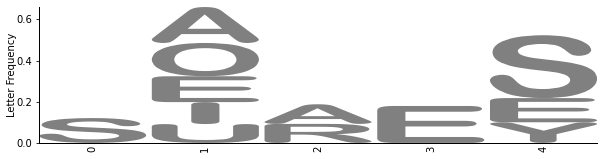

In [25]:
we.make_logo(we.all_words, min_freq=0.09)

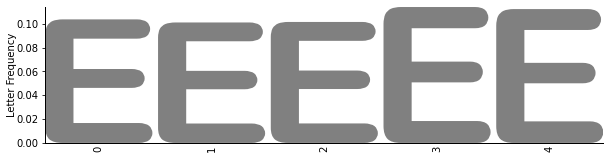

In [28]:
pooled_letters = list("".join(we.all_words[we.all_words["valid"]]["word"]))
# Shuffle the letters
random.shuffle(pooled_letters)
# Make new 5-letter words from the letters
shuf_words = []
for i in range(0, len(pooled_letters), 5):
    shuf_words.append("".join(pooled_letters[i:i+5]))
# Oranize - can ignore
shuf_words = pd.Series(shuf_words).to_frame('word')
for i in range(5):
    shuf_words[f'L-{i}'] = shuf_words['word'].apply(lambda x: str(x)[i].upper())
we.make_logo(shuf_words, min_freq=0.09)

We see that E, the most frequent letter, appears most frequently in each position.
So, clearly there's some structure here.

In [114]:
parts = []
for i in we.letter_cols:
    parts.append(we.all_words[i].value_counts() / len(we.all_words))
matrix = pd.concat(parts, axis=1)
def get_pos_score(word):
    score = 0
    for pos, let in enumerate(word):
        score += matrix.loc[let][f"L-{pos}"]
    return score / len(word)

pos_scores = we.all_words["word"].apply(get_pos_score).to_frame("score")
pos_scores["word"] = we.all_words["word"]
pos_scores['uniq'] = we.all_words['unique']
pos_scores['valid'] = we.all_words['valid']
pos_scores.sort_values(["score"], ascending=False, inplace=True)
pos_scores[(pos_scores["uniq"] == 5) & (pos_scores['valid'])].head()

,score,word,uniq,valid
1752,0.130558,TORUS,5,True
1159,0.128400,BONUS,5,True
1607,0.120136,SANER,5,True
2067,0.117129,BONEY,5,True
269,0.114786,FOCUS,5,True


In [113]:
scores.loc['TORUS'] = we.evaluate_first_word("TORUS", samples=3,n=500)
scores

,speed,loss
later,4.226006,10.000000
irate,4.272285,10.600000
inter,4.263323,11.400000
liner,4.343849,11.200000
alert,4.242685,8.933333
tails,4.151961,9.666667
trail,4.163780,9.600000
AEROS,4.295419,12.333333
AROSE,4.333333,13.133333
TORUS,4.221020,9.066667


# DiGram

<AxesSubplot:xlabel='index', ylabel='Freq'>

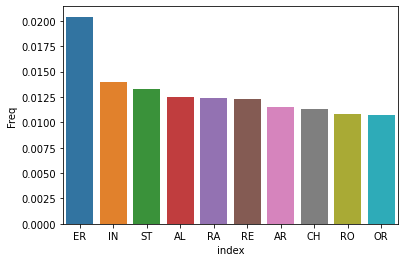

In [4]:
#A-Z in word at all - give them all neighbors
def pair_counter(word):
    c = Counter()
    for i in range(len(word) - 1):
        c[word[i:i+2]] += 1
    return c
parts = we.all_words[we.all_words['valid']]['word'].apply(pair_counter)
digram = pd.DataFrame(list(parts)).fillna(0)
summary = (digram.sum().sort_values(ascending=False) / digram.sum().sum()).to_frame('Freq')
sb.barplot(data=summary.head(10).reset_index(), y="Freq", x='index')

In [117]:
def pair_freq_score(word):
    scr = 0
    for i in range(0, len(word) - 1):
        scr += summary.loc[word[i:i+2]]
    return scr
subset = we.all_words['valid'] & (we.all_words['unique'] == 5)
candidates = we.all_words[subset][we.letter_cols].isin(list("ERINST")).sum(axis=1)
#candiates['letFreq'] = 
view = we.all_words.loc[candidates[candidates == 5].sort_values(ascending=False).index].copy()
view['di_score'] = view['word'].apply(pair_freq_score)
view.sort_values('di_score', inplace=True, ascending=False)
view.head(5)

,word,valid,L-0,L-1,L-2,L-3,L-4,unique,di_score
461,INTER,True,I,N,T,E,R,5,0.049460
315,INERT,True,I,N,E,R,T,5,0.045032
1297,STERN,True,S,T,E,R,N,5,0.045032
508,STEIN,True,S,T,E,I,N,5,0.038229
2054,RINSE,True,R,I,N,S,E,5,0.032505


# Score these 5 words - They're better, but there's gotta be more

In [82]:
for i in view.head(3)['word']:
    scores.loc[i.lower()] = we.evaluate_first_word(i, samples=3,n=500, plot=False)
scores.loc['tails'] = we.evaluate_first_word('tails', samples=3,n=500, plot=False)
scores.loc['trail'] = we.evaluate_first_word('trail', samples=3,n=500, plot=False)
scores

,speed,loss
later,4.226006,10.000000
irate,4.272285,10.600000
inter,4.263323,11.400000
liner,4.343849,11.200000
alert,4.242685,8.933333
tails,4.151961,9.666667
trail,4.163780,9.600000


In [2]:
def pca_analysis(data):    
    n_components = 5
    comp_header = ['pc%d' % (_+1) for _ in range(n_components)]
    x = PCA(n_components=n_components)
    principalComponents = x.fit_transform(data.values)
    principalDf = pd.DataFrame(data = principalComponents,
                               columns = comp_header)
    principalDf['word'] = we.all_words[we.all_words['valid']]['word']#header#
    print("Explained variance")
    print(x.explained_variance_ratio_)

    # Clustering
    clust = cluster.KMeans(3, random_state=2)
    clust.fit(principalDf[['pc1', 'pc2', 'pc3', 'pc4', 'pc5']])
    labels = pd.Series(clust.labels_, name="label", index=principalDf.index, dtype=str)
    principalDf['label'] = labels
    
    # Make the plot
    g = sb.PairGrid(data=principalDf, vars=comp_header, hue='label')
    g.map_offdiag(sb.scatterplot)#, alpha=0.2)
    g.map_diag(sb.histplot)
    plt.show()
    
    # Show the cluster logos
    for lab, d in principalDf.groupby(['label']):
        print('label', lab)
        view = we.all_words[we.all_words['word'].isin(d['word'])]
        display(we.letter_summary(view).head())
        display(view[(view['valid']) & (view['unique'] == 5)].sample(5))
        print(len(view['valid']), 'valid words')
        we.make_logo(view)
    

Explained variance
[0.10962003 0.08983152 0.08022298 0.07605137 0.0693664 ]


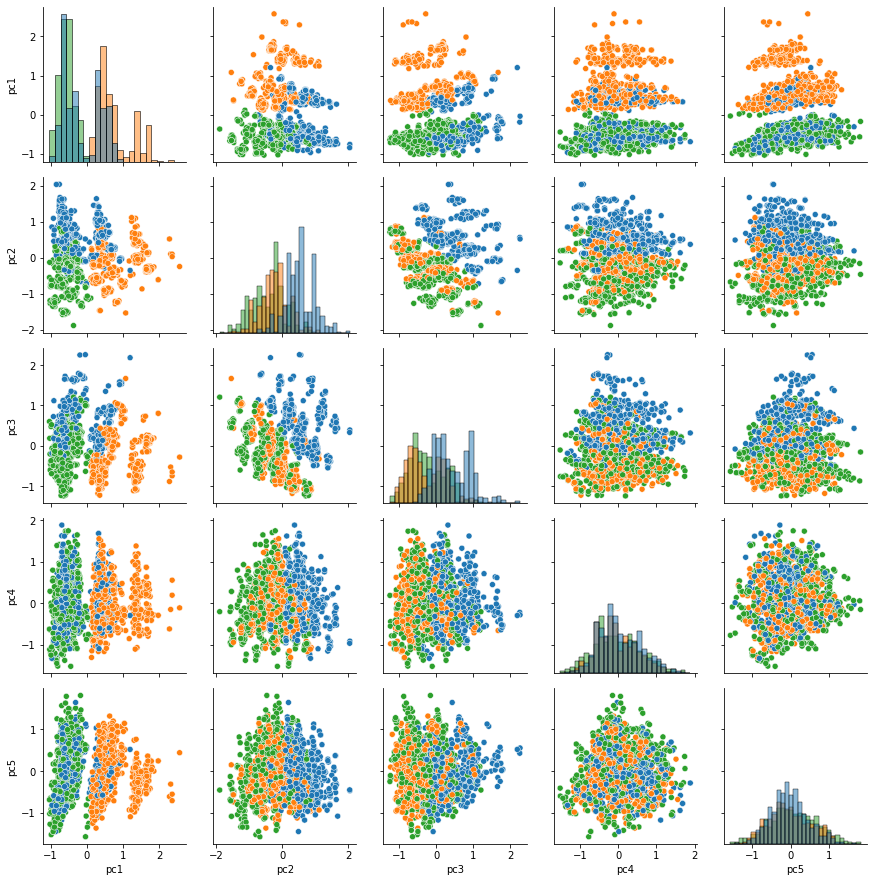

label 0


,count,freq
value,,
A,850,0.998825
E,344,0.404230
R,313,0.367803
L,276,0.324324
T,238,0.279671


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
2275,LOAMY,True,L,O,A,M,Y,5
984,EARTH,True,E,A,R,T,H,5
1231,SPACE,True,S,P,A,C,E,5
1686,CAIRN,True,C,A,I,R,N,5
1272,TRAMP,True,T,R,A,M,P,5


851 valid words


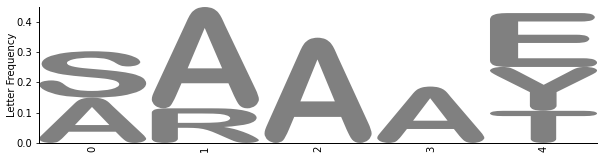

label 1


,count,freq
value,,
O,375,0.494071
I,307,0.404480
U,265,0.349144
T,244,0.321476
R,225,0.296443


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
2099,TRUCK,True,T,R,U,C,K,5
993,HUSKY,True,H,U,S,K,Y,5
386,PINTO,True,P,I,N,T,O,5
1453,VYING,True,V,Y,I,N,G,5
1091,LURID,True,L,U,R,I,D,5


759 valid words


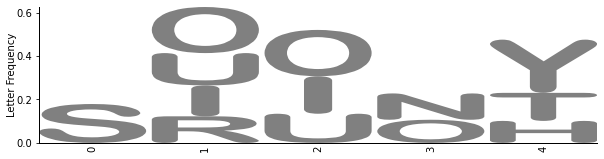

label 2


,count,freq
value,,
E,705,1.000000
R,299,0.424113
I,210,0.297872
O,186,0.263830
T,185,0.262411


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
1648,BEGIN,True,B,E,G,I,N,5
1314,LEMUR,True,L,E,M,U,R,5
196,REBUS,True,R,E,B,U,S,5
723,HOUSE,True,H,O,U,S,E,5
2208,RELIC,True,R,E,L,I,C,5


705 valid words


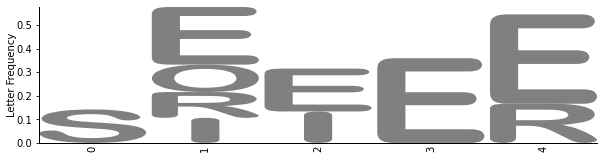

In [130]:
#A-Z in word at all - give them all neighbors
header = []
parts = []
for i in range(ord('A'), ord('Z') + 1):
    letter = chr(i)
    header.append(letter)
    has_letter = we.all_words[we.all_words['valid']][we.letter_cols].isin([letter]).sum(axis=1)
    #has_letter['letter'] = letter
    parts.append(has_letter)
data = pd.concat(parts, axis=1)
data.columns = header
#A-Z in a position - give them all edges

#Then I hunt for neighborhoods? Or some kind of way to separate pieces.
data.head()

pca_analysis(data)

# DiGram PCA

Explained variance
[0.02178457 0.01943755 0.01794741 0.01714166 0.01654139]


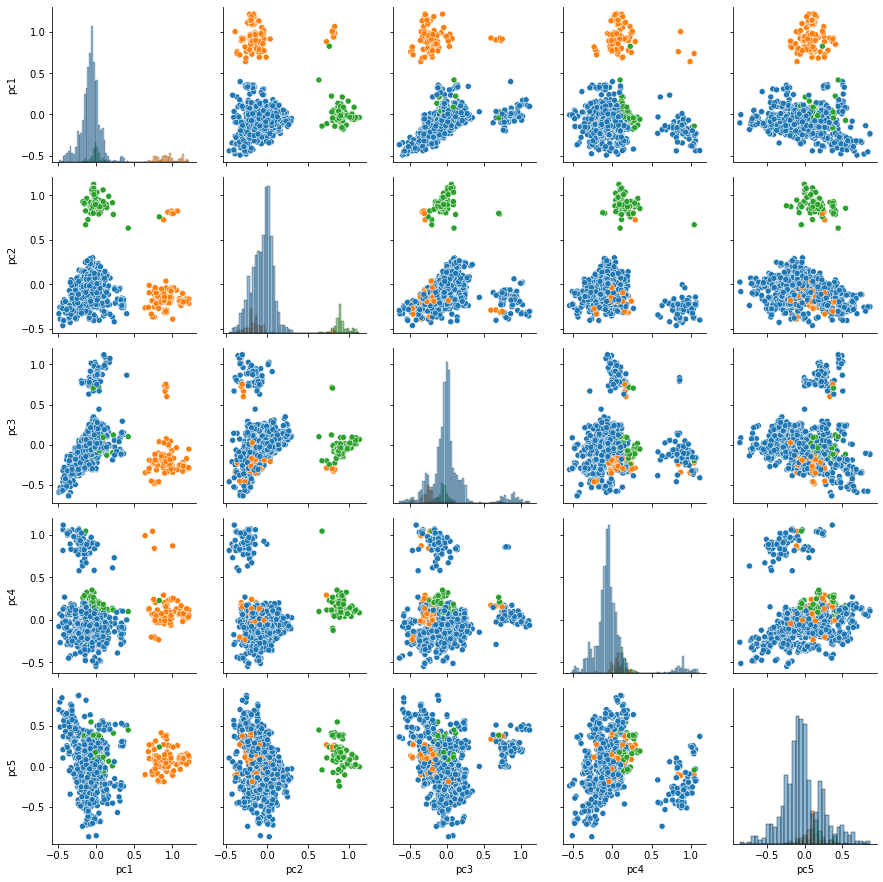

label 0


,count,freq
value,,
E,44,0.419048
A,41,0.390476
N,35,0.333333
I,34,0.323810
T,33,0.314286


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
900,JOKER,True,J,O,K,E,R,5
1430,PHONY,True,P,H,O,N,Y,5
837,STUNG,True,S,T,U,N,G,5
299,STAIR,True,S,T,A,I,R,5
821,BRAIN,True,B,R,A,I,N,5


105 valid words


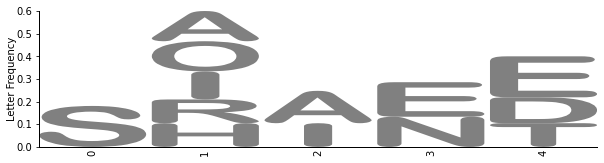

label 1


,count,freq
value,,
E,634,0.470326
A,528,0.391691
R,493,0.365727
O,399,0.295994
L,390,0.289318


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
999,STEAL,True,S,T,E,A,L,5
297,FORAY,True,F,O,R,A,Y,5
313,PLANT,True,P,L,A,N,T,5
523,PINEY,True,P,I,N,E,Y,5
1308,DEITY,True,D,E,I,T,Y,5


1348 valid words


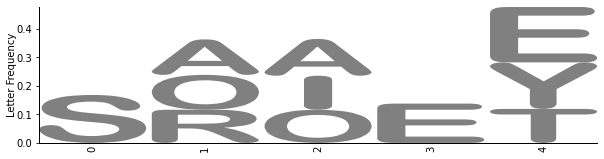

label 2


,count,freq
value,,
E,46,0.407080
R,43,0.380531
A,41,0.362832
O,32,0.283186
L,32,0.283186


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
1208,BLUNT,True,B,L,U,N,T,5
1052,BUSHY,True,B,U,S,H,Y,5
335,SLUNG,True,S,L,U,N,G,5
1013,DONUT,True,D,O,N,U,T,5
6,FOCAL,True,F,O,C,A,L,5


113 valid words


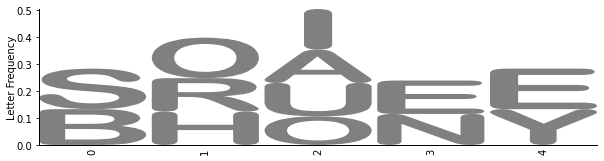

In [5]:
pca_analysis(digram[we.all_words['unique'] == 5])